In [15]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as autograd
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from logReg import LogitReg
from torch.nn import Parameter
from influence import *
from util import *
import hessian as hess
from pathlib import Path
import time
from experiments import *
from sklearn.metrics import mean_squared_error

In [2]:
'''training_data = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True),shuffle=True)
test_data =  torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True),shuffle=True)



X_train = training_data.dataset.train_data.data.reshape(-1,784).type(torch.FloatTensor)/255
y_train = training_data.dataset.train_labels.data
X_test = test_data.dataset.test_data.data.reshape(-1,784).type(torch.FloatTensor)/255
y_test = test_data.dataset.test_labels

np.savez("../data/training_data.npz", X=X_train, Y= y_train)
np.savez("../data/test_data.npz", X=X_test, Y= y_test)'''

X_train = torch.from_numpy(np.load("../data/training_data.npz")["X"])
y_train = torch.from_numpy(np.load("../data/training_data.npz")["Y"])
X_test = torch.from_numpy(np.load("../data/test_data.npz")["X"])
y_test = torch.from_numpy(np.load("../data/test_data.npz")["Y"])



max_iter = 100
D_in = X_train.shape[1]
D_out = 10
N = X_train.shape[0]
weight_decay = 0.01

cls = LogitReg(max_iter, D_in, D_out, N, weight_decay)
cls.fit(X_train,y_train)
print("Training loss {}".format(cls.loss_fn(X_train, y_train)))
print( "Training accuracy {}". format( cls.score(X_train,y_train)))
print( "Test loss {}". format( cls.loss_fn(X_test,y_test)))
print( "Test accuracy {}". format( cls.score(X_test,y_test)))


LBFGS training took [66] iter.
After training with LBFGS: 
Training loss 0.41001251339912415
a 53993.0 b 60000
Training accuracy 0.8998833298683167
Test loss 0.3923059105873108
a 9056.0 b 10000
Test accuracy 0.9056000113487244


In [ ]:
def hessian_k_leave_out( model, X_train, y_train, X_test, y_test, n_trials=1, num_to_remove=5, verify_influence = False, 
                         scale=25, depth=5000, batch_size = 1, num_samples=10):
       
        N = model.num_train_examples
        
        predicted = model.predict(X_test)
        test_indices = torch.nonzero(predicted != y_test)[0:n_trials]
        params_diff = np.zeros((n_trials, 3))
        loss_diff = np.zeros((n_trials, 3))
        time_diff = np.zeros((n_trials,2))
        train_indices = np.zeros((n_trials,num_to_remove))
        
        h_ncg = hess.Hessian( model, X_train, y_train )
        h_ncg.initialize(X_train, y_train)
        
        h_lissa = hess.Hessian( model, X_train, y_train )
        
        
        for trial in range(n_trials):
            np.random.seed()
            indices_to_remove = np.random.choice(N, num_to_remove)
            
            train_indices[trial,:] = indices_to_remove
            test_idx = test_indices[trial]
           
            X_tr, y_tr, X_te, y_te = split_data_k( indices_to_remove, test_idx, X_train, y_train, X_test, y_test)

            tr_grad, train_loss = h_ncg.get_loss_gradient(X_tr, y_tr)
            test_grad, test_loss = h_ncg.get_loss_gradient(X_te, y_te)
            
            v = test_grad.detach().numpy()
            
            print("Calculating HVP inverse using ncg")
            t0 = time.time()
            hvp_ncg = h_ncg.get_inverse_hvp_cg(test_grad, max_iterations = 100)
            print(hvp_ncg.dtype)
            t1 = time.time()
            
            time_diff[trial,0] = t1-t0
            
            
            params_diff[trial, 0] = np.linalg.norm(np.array(hvp_ncg) * (num_to_remove/N))
            loss_diff[trial, 0] = np.sum(hvp_ncg * tr_grad.detach().numpy())*(num_to_remove/N)
            
            print("Calculating HVP inverse using lissa")
            
            t2 = time.time()
            hvp_lissa = stochastic_hessian_Lissa(h_lissa, X_train, y_train, test_grad, scale=scale, 
                                                 depth=depth, batch_size = batch_size, num_samples= num_samples)
            
            t3 = time.time() 
            hvp_lissa = hvp_lissa.detach().numpy()
            
            time_diff[trial,1] = t3-t2
            
  
            params_diff[trial, 1] = np.linalg.norm(hvp_lissa) * (num_to_remove/N)
            loss_diff[trial, 1] = np.sum(hvp_lissa * tr_grad.detach().numpy())*(num_to_remove/N)

            if( verify_influence):
                cls_leave = LogitReg(model.iterations, model.D_in, model.D_out, N, model.weight_decay)
                number = np.array(range(N))
                number = np.delete(number, indices_to_remove)
                
                cls_leave.fit( X_train[number,:], y_train[number])
                actual_difference = cls_leave.fc1.weight.view(-1) - model.fc1.weight.view(-1)
                 
                params_diff[trial,2] = torch.norm(actual_difference).detach().numpy()
                loss_diff[trial,2] =  cls_leave.loss_fn(X_te, y_te) - model.loss_fn(X_te, y_te)
                print( "Predicted loss  ncg{} liss {} actual loss {}".format(loss_diff[trial,0]
                                                                            ,loss_diff[trial,1],
                                                                             loss_diff[trial,2]))
        
        print( time_diff )
        np.savez("../data/computation/hess_diffs_" + str(num_to_remove) + ".npz",r = {"params":params_diff, 
                                                                                      "loss":loss_diff, 
                                                                                      "test_indices": test_indices,
                                                                                      "train_indices": train_indices, 
                                                                                      "K":num_to_remove,
                                                                                      "time_diff":time_diff,
                                                                    })


In [ ]:
count = 1000
while( count >= 10 ):
    print("Leave-out-k-{}".format(count))
    hessian_k_leave_out( cls, X_train, y_train, X_test, y_test, n_trials = 1, num_to_remove=count, verify_influence = True, 
                     scale=25, depth=5000, batch_size = 1, num_samples=5)
    count = count - 100
    break

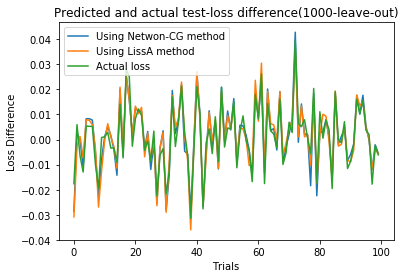

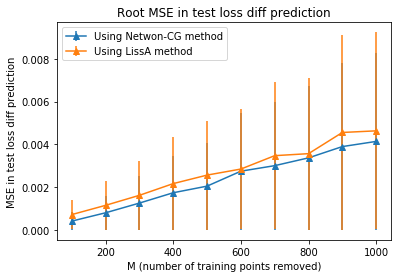

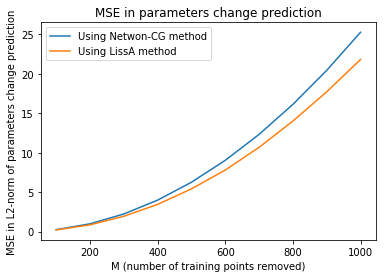

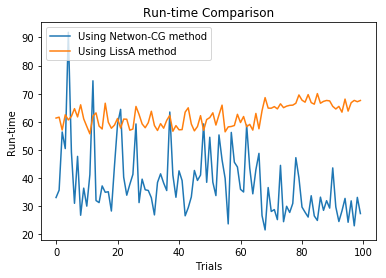

In [38]:
count = 100
a = range(100)
loss_data = np.zeros((10,2))
params_data = np.zeros((10,2))
time_data = np.zeros((10,2))
k = 0
arr = []
mean_data = np.zeros((10,2))
std_data = np.zeros((10,2))
while( count <= 1000 ):
    

    res = np.load("../data/computation/hess_diffs_" + str(count) + ".npz")["r"].item()
    loss_data[k,0] = np.sqrt(mean_squared_error(res["loss"][:,0],res["loss"][:,2]))
    loss_data[k,1] = np.sqrt(mean_squared_error(res["loss"][:,1],res["loss"][:,2]))
    params_data[k,0] = mean_squared_error(res["params"][:,0],res["params"][:,2])
    params_data[k,1] = mean_squared_error(res["params"][:,1],res["params"][:,2])
    time_data = res["time_diff"]
    arr.append(count)
 
    
    std_data[k,0] = np.std(res["loss"][:,0] - res["loss"][:,2])
    std_data[k,1] = np.std(res["loss"][:,1] - res["loss"][:,2])
    
    if count == 1000:
        fig, ax = plt.subplots()

        ax.plot(a, res["loss"][:,0], label='Using Netwon-CG method')
        ax.plot(a, res["loss"][:,1], label='Using LissA method')
        ax.plot(a, res["loss"][:,2], label='Actual loss')
        plt.xlabel("Trials")
        plt.ylabel("Loss Difference")
        plt.title("Predicted and actual test-loss difference(1000-leave-out)")
        legend = ax.legend(loc="upper left")
        plt.savefig("../final_plot/1000_leave_ou.png")


        # Put a nicer background color on the legend.
        

        plt.show()
    count = count + 100
    k = k + 1
fig, ax = plt.subplots()
    
plt.errorbar(arr,loss_data[:,0],yerr= std_data[:,0], fmt='-^', label='Using Netwon-CG method') 
plt.errorbar(arr,loss_data[:,1],yerr= std_data[:,1], fmt='-^', label='Using LissA method') 
#ax.plot(arr, loss_data[:,0],  label='Using Netwon-CG method')
#ax.plot(arr, loss_data[:,1], label='Using LissA method')
plt.xlabel("M (number of training points removed)")
plt.ylabel("MSE in test loss diff prediction")
legend = ax.legend(loc="upper left")
plt.title("Root MSE in test loss diff prediction")
plt.savefig('../final_plot/loss_k_leave_out.png')

fig, ax = plt.subplots()

ax.plot(arr, params_data[:,0], label='Using Netwon-CG method')
ax.plot(arr, params_data[:,1], label='Using LissA method')
plt.xlabel("M (number of training points removed)")
plt.ylabel("MSE in L2-norm of parameters change prediction")
legend = ax.legend(loc="upper left")
plt.title("MSE in parameters change prediction")
plt.savefig('../final_plot/k_params_change.png')

fig, ax = plt.subplots()
ax.plot(a, time_data[:,0], label='Using Netwon-CG method')
ax.plot(a, time_data[:,1], label='Using LissA method')
plt.xlabel("Trials")
plt.ylabel("Run-time")
legend = ax.legend(loc="upper left")
plt.title("Run-time Comparison")
plt.savefig('../final_plot/run_time_comparison.png')
